# Introduction

Sales forecasting is the process of estimating future revenue by predicting the amount of product or services a sales unit will sell in the next week, month, quarter, or year. Sales forecasting adds value across an organization. Finance, for example, relies on forecasts to develop budgets for capacity plans and hiring. Production uses sales forecasts to plan their cycles. Forecasts help sales ops with territory and quota planning, supply chain with material purchases and production capacity, and sales strategy with channel and partner strategies. On the other hand, Predict a little over, and grocers are stuck with overstocked, perishable goods. Guess a little under, and popular items quickly sell out, leading to lost revenue and upset customers. More accurate forecasting, thanks to machine learning, could help ensure retailers please customers by having just enough of the right products at the right time.


We will use time-series forecasting to forecast store sales on data from Corporación Favorita, a large Ecuadorian-based grocery retailer. In this case, we will predict sales for the thousands of product families sold at Favorita stores located in Ecuador. The training data includes dates, store and product information, whether that item was being promoted, as well as the sales numbers. Additional files include supplementary information that may be useful in building our models.

# Part 1: Data Preparation

In [87]:
# import modules
import numpy as np 
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from pylab import rcParams
from matplotlib import rc
from pandas.plotting import register_matplotlib_converters
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from keras.models import Sequential
from keras.layers import Dense, Embedding, GRU, LSTM, SpatialDropout1D, SimpleRNN, Flatten, Bidirectional, Dropout
from sklearn.model_selection import train_test_split
from keras.utils.np_utils import to_categorical
from keras.callbacks import EarlyStopping
from keras import layers
from keras.layers.convolutional import Conv1D
from keras.layers.convolutional import MaxPooling1D
from sklearn import metrics
from sklearn.preprocessing import LabelEncoder,MinMaxScaler
import tensorflow as tf
from datetime import datetime
from keras.constraints import nonneg
from sklearn.metrics import mean_squared_log_error
from sklearn.metrics import mean_squared_error
import keras
from keras.callbacks import EarlyStopping

import warnings
warnings.filterwarnings('ignore')

## Leading Data

- The training data, comprising time series of features store_nbr, family, and onpromotion as well as the target sales.
- store_nbr identifies the store at which the products are sold.
- family identifies the type of product sold.
- sales gives the total sales for a product family at a particular store at a given date. Fractional values are possible since products can be sold in fractional units (1.5 kg of cheese, for instance, as opposed to 1 bag of chips).
- onpromotion gives the total number of items in a product family that were being promoted at a store at a given date.

In [2]:
# read the dataset 
train = pd.read_csv("train.csv")
print(train.shape)
train.head()

(3000888, 6)


,id,date,store_nbr,family,sales,onpromotion
0,0,2013-01-01,1,AUTOMOTIVE,0.0,0
1,1,2013-01-01,1,BABY CARE,0.0,0
2,2,2013-01-01,1,BEAUTY,0.0,0
3,3,2013-01-01,1,BEVERAGES,0.0,0
4,4,2013-01-01,1,BOOKS,0.0,0


- The test data, having the same features as the training data. We will predict the target sales for the dates in this file.
- The dates in the test data are for the 15 days after the last date in the training data.

In [3]:
# read the dataset
test = pd.read_csv("test.csv")
print(test.shape)
test.head()

(28512, 5)


,id,date,store_nbr,family,onpromotion
0,3000888,2017-08-16,1,AUTOMOTIVE,0
1,3000889,2017-08-16,1,BABY CARE,0
2,3000890,2017-08-16,1,BEAUTY,2
3,3000891,2017-08-16,1,BEVERAGES,20
4,3000892,2017-08-16,1,BOOKS,0


- Holidays and Events, with metadata
- NOTE: Pay special attention to the transferred column. A holiday that is transferred officially falls on that calendar day, but was moved to another date by the government. A transferred day is more like a normal day than a holiday. To find the day that it was actually celebrated, look for the corresponding row where type is Transfer. For example, the holiday Independencia de Guayaquil was transferred from 2012-10-09 to 2012-10-12, which means it was celebrated on 2012-10-12. Days that are type Bridge are extra days that are added to a holiday (e.g., to extend the break across a long weekend). These are frequently made up by the type Work Day which is a day not normally scheduled for work (e.g., Saturday) that is meant to payback the Bridge.
- Additional holidays are days added a regular calendar holiday, for example, as typically happens around Christmas (making Christmas Eve a holiday).

In [4]:
# read the dataset
holiday = pd.read_csv("holidays_events.csv")
print(holiday.shape)
holiday.head()

(350, 6)


,date,type,locale,locale_name,description,transferred
0,2012-03-02,Holiday,Local,Manta,Fundacion de Manta,False
1,2012-04-01,Holiday,Regional,Cotopaxi,Provincializacion de Cotopaxi,False
2,2012-04-12,Holiday,Local,Cuenca,Fundacion de Cuenca,False
3,2012-04-14,Holiday,Local,Libertad,Cantonizacion de Libertad,False
4,2012-04-21,Holiday,Local,Riobamba,Cantonizacion de Riobamba,False


- Store metadata, including city, state, type, and cluster.
- cluster is a grouping of similar stores.

In [5]:
# read the dataset
store = pd.read_csv('stores.csv')
print(store.shape)
store.head()

(54, 5)


,store_nbr,city,state,type,cluster
0,1,Quito,Pichincha,D,13
1,2,Quito,Pichincha,D,13
2,3,Quito,Pichincha,D,8
3,4,Quito,Pichincha,D,9
4,5,Santo Domingo,Santo Domingo de los Tsachilas,D,4


- Daily oil price. Includes values during both the train and test data timeframes.

In [6]:
# read the dataset
oil = pd.read_csv('oil.csv')
print(oil.shape)
oil.tail()

(1218, 2)


,date,dcoilwtico
1213,2017-08-25,47.65
1214,2017-08-28,46.40
1215,2017-08-29,46.46
1216,2017-08-30,45.96
1217,2017-08-31,47.26


In [7]:
# read the dataset
trans = pd.read_csv('transactions.csv')
print(trans.shape)
trans.tail()

(83488, 3)


,date,store_nbr,transactions
83483,2017-08-15,50,2804
83484,2017-08-15,51,1573
83485,2017-08-15,52,2255
83486,2017-08-15,53,932
83487,2017-08-15,54,802


## Data Cleaning

Let's merge datasets to one dataset so that we can analyze them together and build models. 

In [8]:
# check the data types of date columns for each data set
print(train['date'].dtypes)
print(test['date'].dtypes)
print(holiday['date'].dtypes)
print(oil['date'].dtypes)
print(trans['date'].dtypes)

object
object
object
object
object


In [9]:
# change the data types of date varaibles to datetime
train['date'] = pd.to_datetime(train['date'])
test['date'] = pd.to_datetime(test['date'])
holiday['date'] = pd.to_datetime(holiday['date'])
oil['date'] = pd.to_datetime(oil['date'])
trans['date'] = pd.to_datetime(trans['date'])

In [10]:
# combine train and store into one data set
train = pd.merge(train, store, on = 'store_nbr')
print(train.shape)
train.head()

(3000888, 10)


,id,date,store_nbr,family,sales,onpromotion,city,state,type,cluster
0,0,2013-01-01,1,AUTOMOTIVE,0.0,0,Quito,Pichincha,D,13
1,1,2013-01-01,1,BABY CARE,0.0,0,Quito,Pichincha,D,13
2,2,2013-01-01,1,BEAUTY,0.0,0,Quito,Pichincha,D,13
3,3,2013-01-01,1,BEVERAGES,0.0,0,Quito,Pichincha,D,13
4,4,2013-01-01,1,BOOKS,0.0,0,Quito,Pichincha,D,13


In [11]:
# combine train and store into one data set
test = pd.merge(test, store, on = 'store_nbr')
print(test.shape)
test.head()

(28512, 9)


,id,date,store_nbr,family,onpromotion,city,state,type,cluster
0,3000888,2017-08-16,1,AUTOMOTIVE,0,Quito,Pichincha,D,13
1,3000889,2017-08-16,1,BABY CARE,0,Quito,Pichincha,D,13
2,3000890,2017-08-16,1,BEAUTY,2,Quito,Pichincha,D,13
3,3000891,2017-08-16,1,BEVERAGES,20,Quito,Pichincha,D,13
4,3000892,2017-08-16,1,BOOKS,0,Quito,Pichincha,D,13


If the value of the variable 'transferred' is true, people work on the day and have a day-off on another day. To leave only the data people actually didn't go to work, let's filter out the rows which have the true value for the variable 'transferred'.

In [12]:
holiday = holiday[holiday['transferred'] == False]
holiday.head()

,date,type,locale,locale_name,description,transferred
0,2012-03-02,Holiday,Local,Manta,Fundacion de Manta,False
1,2012-04-01,Holiday,Regional,Cotopaxi,Provincializacion de Cotopaxi,False
2,2012-04-12,Holiday,Local,Cuenca,Fundacion de Cuenca,False
3,2012-04-14,Holiday,Local,Libertad,Cantonizacion de Libertad,False
4,2012-04-21,Holiday,Local,Riobamba,Cantonizacion de Riobamba,False


In [13]:
# subset holiday data to each type of holiday 
national = holiday[holiday['locale'] == 'National']
national = national.drop(['description','transferred'], axis=1)
regional = holiday[holiday['locale'] == 'Regional']
regional = regional.drop(['description','transferred'], axis=1)
local = holiday[holiday['locale'] == 'Local']
local = local.drop(['description','transferred'], axis=1)

In [14]:
# set the appropriate column names to each dataset 
national.columns = ['date', 'holi_type', 'holi_nation', 'nation']
regional.columns = ['date', 'holi_type', 'holi_region', 'state']
local.columns = ['date', 'holi_type', 'holi_local', 'city']

In [15]:
# combine each holiday dataset with train and test dataset respectively
train = pd.merge(train, national, how = 'left', on = 'date')
train = pd.merge(train, regional, how = 'left', on = ['date','state'])
train = pd.merge(train, local, how = 'left', on = ['date','city'])

test = pd.merge(test, national, how = 'left', on = 'date')
test = pd.merge(test, regional, how = 'left', on = ['date','state'])
test = pd.merge(test, local, how = 'left', on = ['date','city'])

The oil dataset didn't have data for weekends so we will combine the dataset with train and test dataset to use the whole dates. Like stock prices, real time oil price is not available on the weekend, which means the latest information is Friday's oil price so we will use ffill(). However, the earliest date which is weekend doesn't have the previous data so we will use bfill for that.

In [16]:
tmp = pd.concat([train, test])
tmp = pd.DataFrame(tmp.groupby('date')['onpromotion'].mean())
tmp.reset_index(inplace=True)
tmp = pd.merge(tmp, oil, how = 'left', on = 'date')
tmp.fillna(method='ffill', inplace=True)
tmp.fillna(method='bfill', inplace=True)
tmp.drop('onpromotion', axis=1, inplace=True)
tmp.head(10)

,date,dcoilwtico
0,2013-01-01,93.14
1,2013-01-02,93.14
2,2013-01-03,92.97
3,2013-01-04,93.12
4,2013-01-05,93.12
5,2013-01-06,93.12
6,2013-01-07,93.20
7,2013-01-08,93.21
8,2013-01-09,93.08
9,2013-01-10,93.81


In [17]:
train = pd.merge(train, tmp, how = 'left', on = 'date')
test = pd.merge(test, tmp, how = 'left', on = 'date')

After merging all the dataset we need to use, let's clean data more using user-defined function.

In [18]:
def data_prep(data):
    data['holi_nation'].fillna(0, inplace=True) # fill null value with zero
    data['holi_region'].fillna(0, inplace=True) # fill null value with zero
    data['holi_local'].fillna(0, inplace=True) # fill null value with zero
    for col in ['holi_nation', 'holi_region', 'holi_local']:
        data.loc[data[col] != 0, col] = 1 # convert values to 1 unless it was null value
    
    # Since we merge three holiday datasets with the master dataset, there are duplicate columns
    # Let's combine them into one
    data.loc[data['holi_nation'] == 1, 'holi_type'] = data.loc[data['holi_nation'] == 1, 'holi_type_x']
    data.loc[data['holi_region'] == 1, 'holi_type'] = data.loc[data['holi_nation'] == 1, 'holi_type_y']   

    data.drop(['id', 'nation', 'holi_type_x', 'holi_type_y'], axis=1, inplace=True) # drop unnecessary columns
    data['dayofweek'] = data['date'].dt.dayofweek # extract features from the datetime column
    data['day'] = data['date'].dt.day # extract features from the datetime column
    data.loc[(data['day'] == 1)|(data['day'] == 16), 'income'] = 1 # Add the new columns indicating when peaple in the public sector are paid
    data['income'].fillna(0, inplace=True) # fill null value with zero 
    data.sort_values(["store_nbr", "family"], ascending = (True, True)) # sort the rows by store numbers and product categories

In [19]:
# apply the function to the train dataset
data_prep(train)
train.head()

,date,store_nbr,family,sales,onpromotion,city,state,type,cluster,holi_nation,holi_region,holi_type,holi_local,dcoilwtico,dayofweek,day,income
0,2013-01-01,1,AUTOMOTIVE,0.0,0,Quito,Pichincha,D,13,1,0,Holiday,0,93.14,1,1,1.0
1,2013-01-01,1,BABY CARE,0.0,0,Quito,Pichincha,D,13,1,0,Holiday,0,93.14,1,1,1.0
2,2013-01-01,1,BEAUTY,0.0,0,Quito,Pichincha,D,13,1,0,Holiday,0,93.14,1,1,1.0
3,2013-01-01,1,BEVERAGES,0.0,0,Quito,Pichincha,D,13,1,0,Holiday,0,93.14,1,1,1.0
4,2013-01-01,1,BOOKS,0.0,0,Quito,Pichincha,D,13,1,0,Holiday,0,93.14,1,1,1.0


In [20]:
# apply the function to the test dataset
data_prep(test)
test.head()

,date,store_nbr,family,onpromotion,city,state,type,cluster,holi_nation,holi_region,holi_type,holi_local,dcoilwtico,dayofweek,day,income
0,2017-08-16,1,AUTOMOTIVE,0,Quito,Pichincha,D,13,0,0,NaN,0,46.8,2,16,1.0
1,2017-08-16,1,BABY CARE,0,Quito,Pichincha,D,13,0,0,NaN,0,46.8,2,16,1.0
2,2017-08-16,1,BEAUTY,2,Quito,Pichincha,D,13,0,0,NaN,0,46.8,2,16,1.0
3,2017-08-16,1,BEVERAGES,20,Quito,Pichincha,D,13,0,0,NaN,0,46.8,2,16,1.0
4,2017-08-16,1,BOOKS,0,Quito,Pichincha,D,13,0,0,NaN,0,46.8,2,16,1.0


In [21]:
# extract the combined data to analyze using Tableau
train.to_csv('train_combined.csv', index=False)

# Part 2: Exploratory Data Analysis

We will use Tableau to explore and analyze our data.

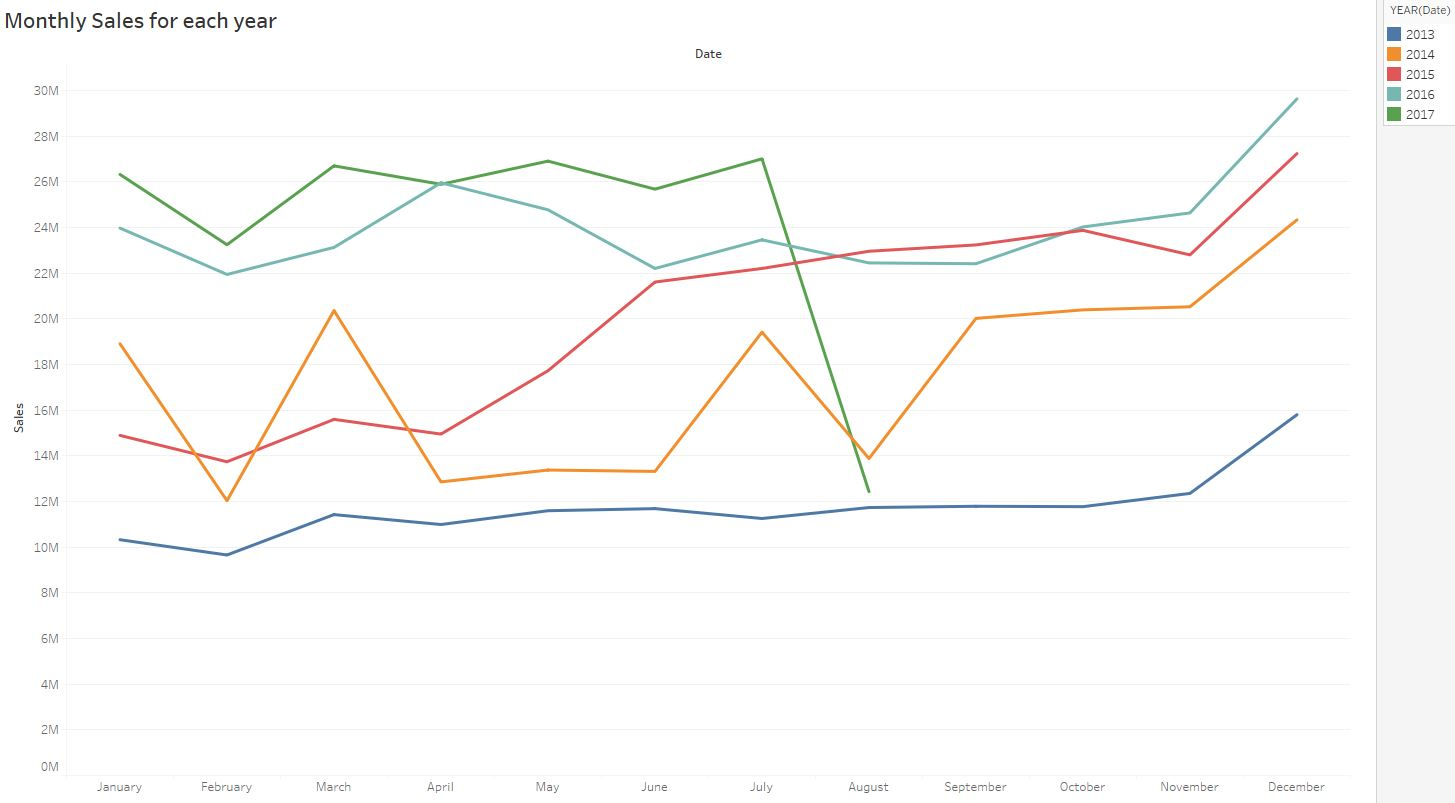

We can see the sales tend to increase at the end of year and then decrease until February. In addition, it seems that the average annual sales have increased over time.

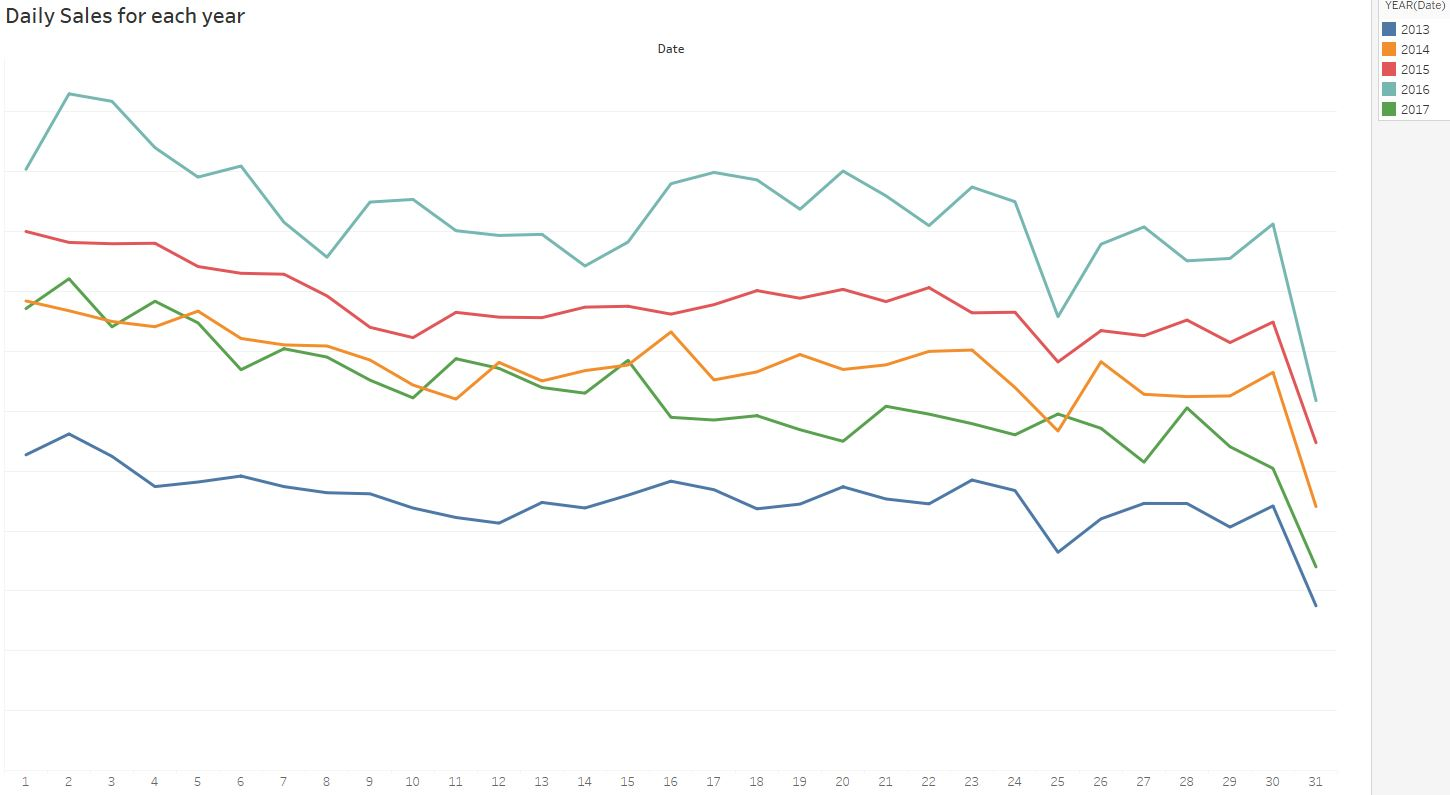

Since wages in the public sector are paid every two weeks on the 15 th and on the last day of the month, the supermarket sales one or two days after the payment day tend to increase. 

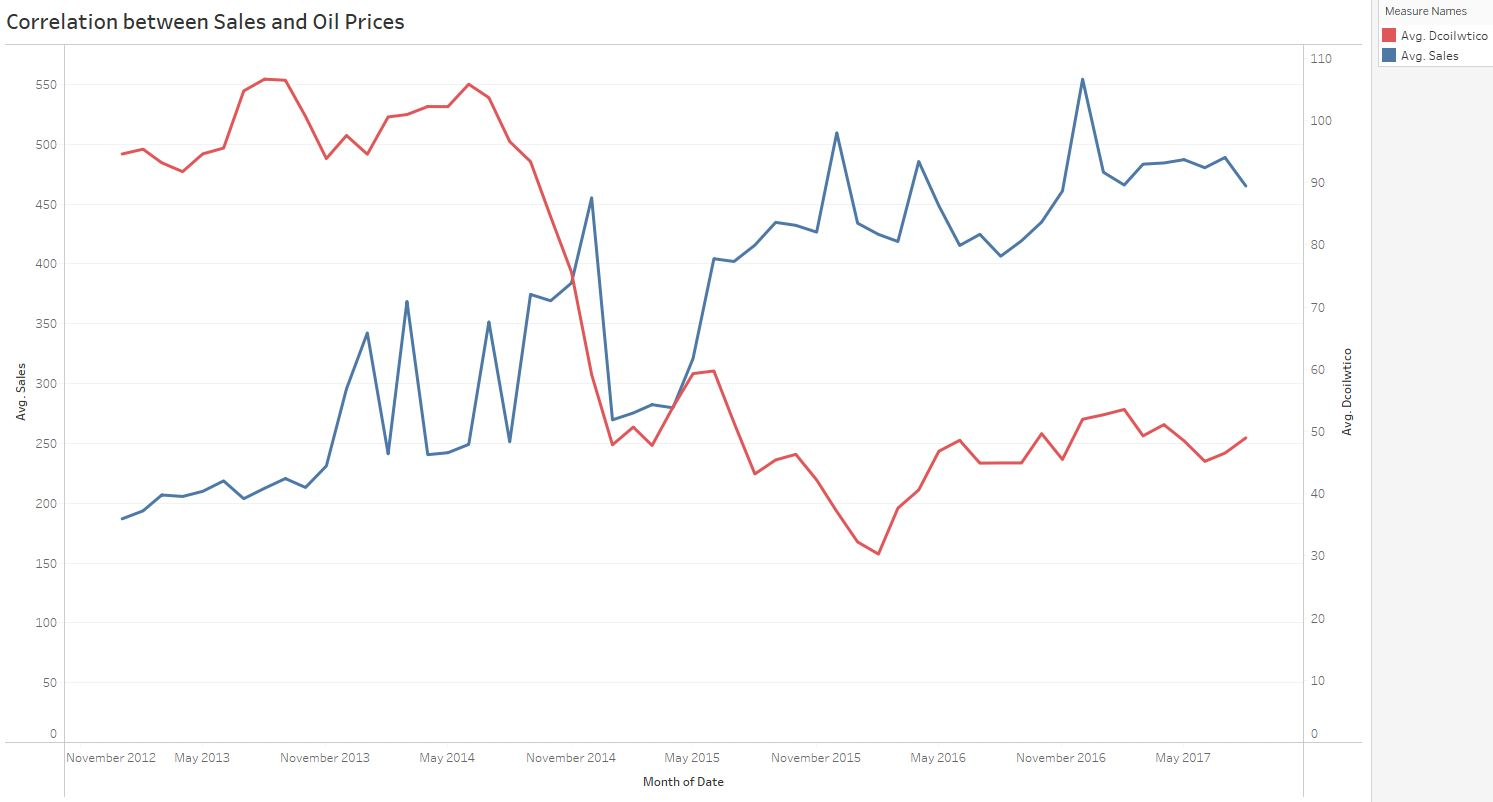

Ecuador is an oil-dependent country and its economic health is highly vulnerable to shocks in oil prices. That is why, the relationship between sales and oil prices is inverse proportion.

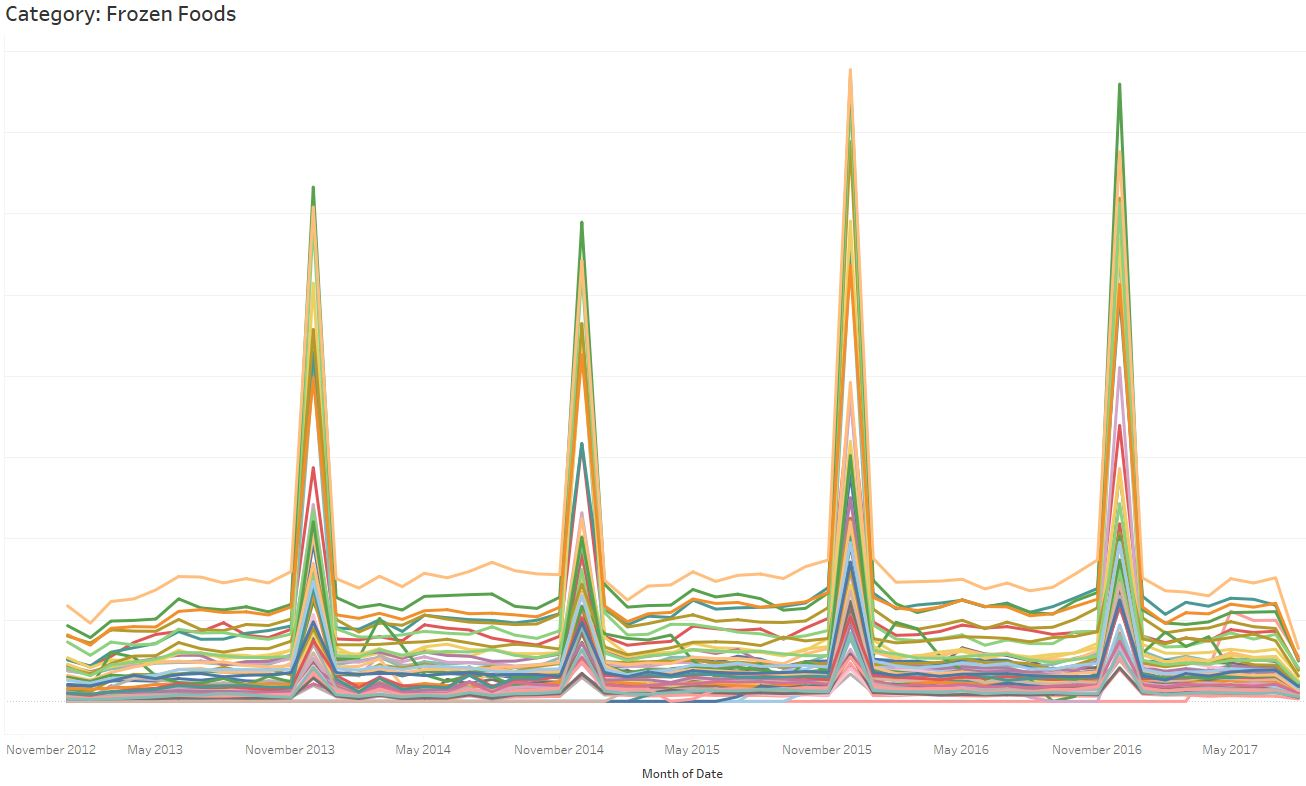

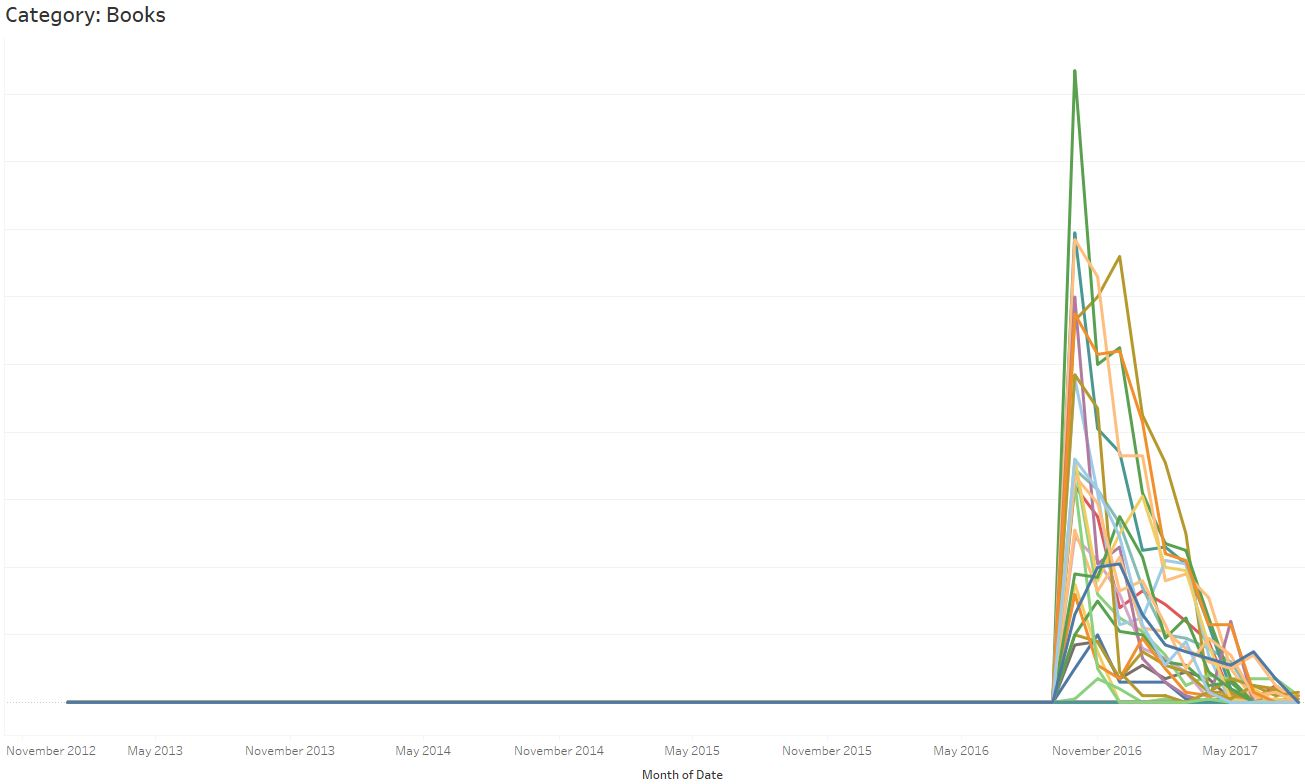

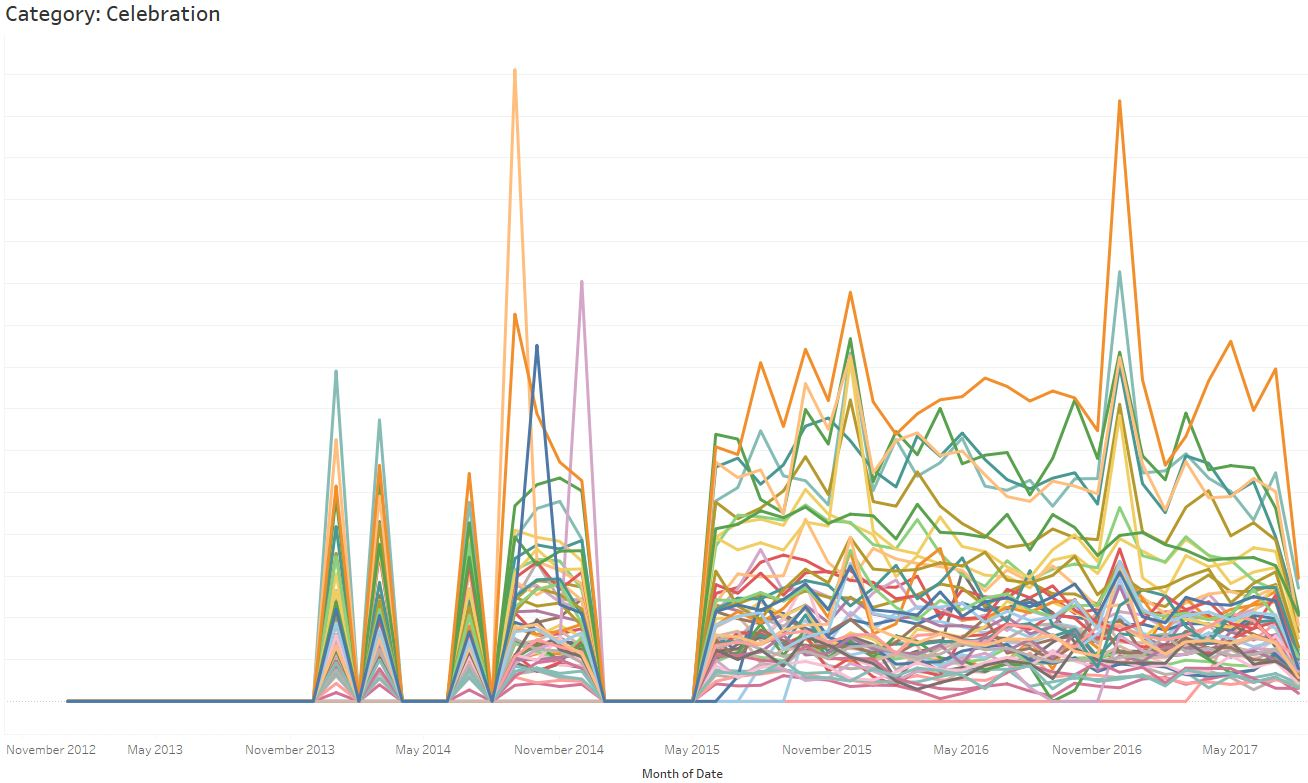

We can see that each category has different sales patterns so models should be built by category separately.

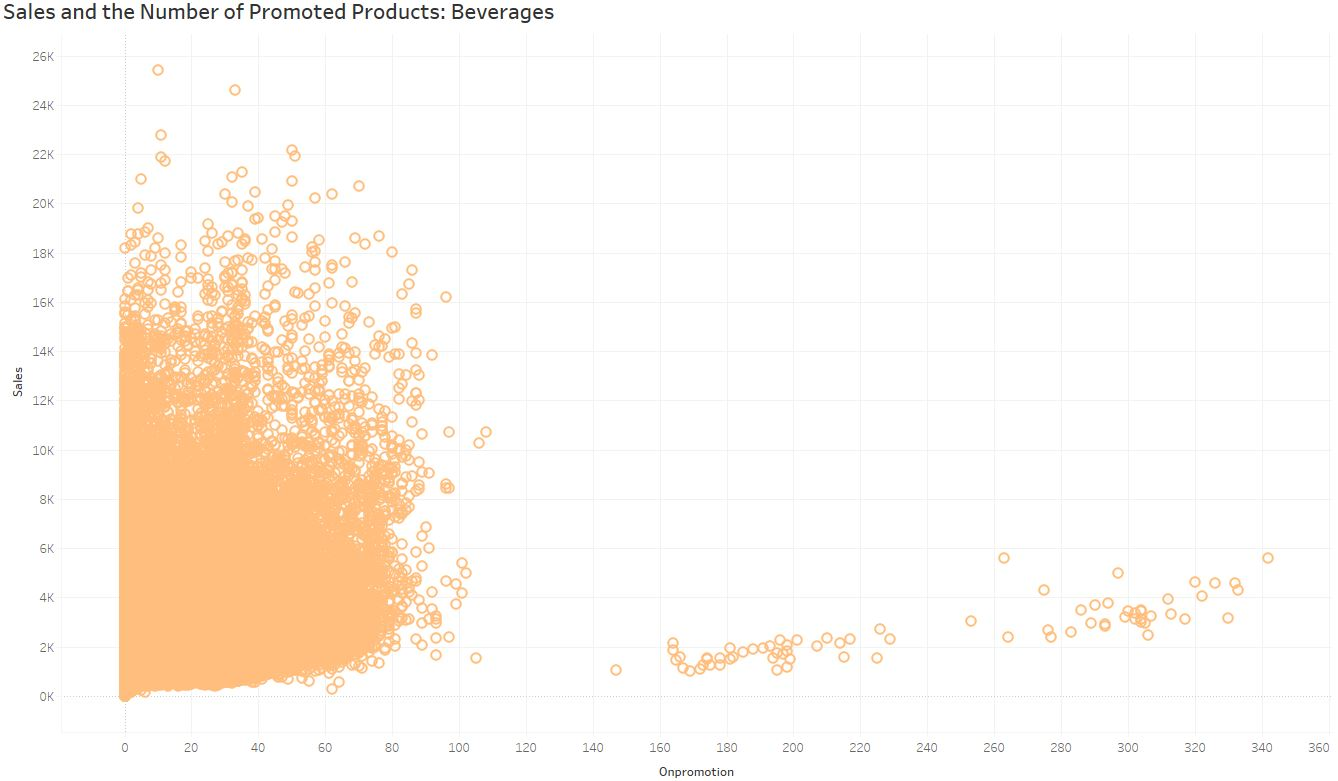

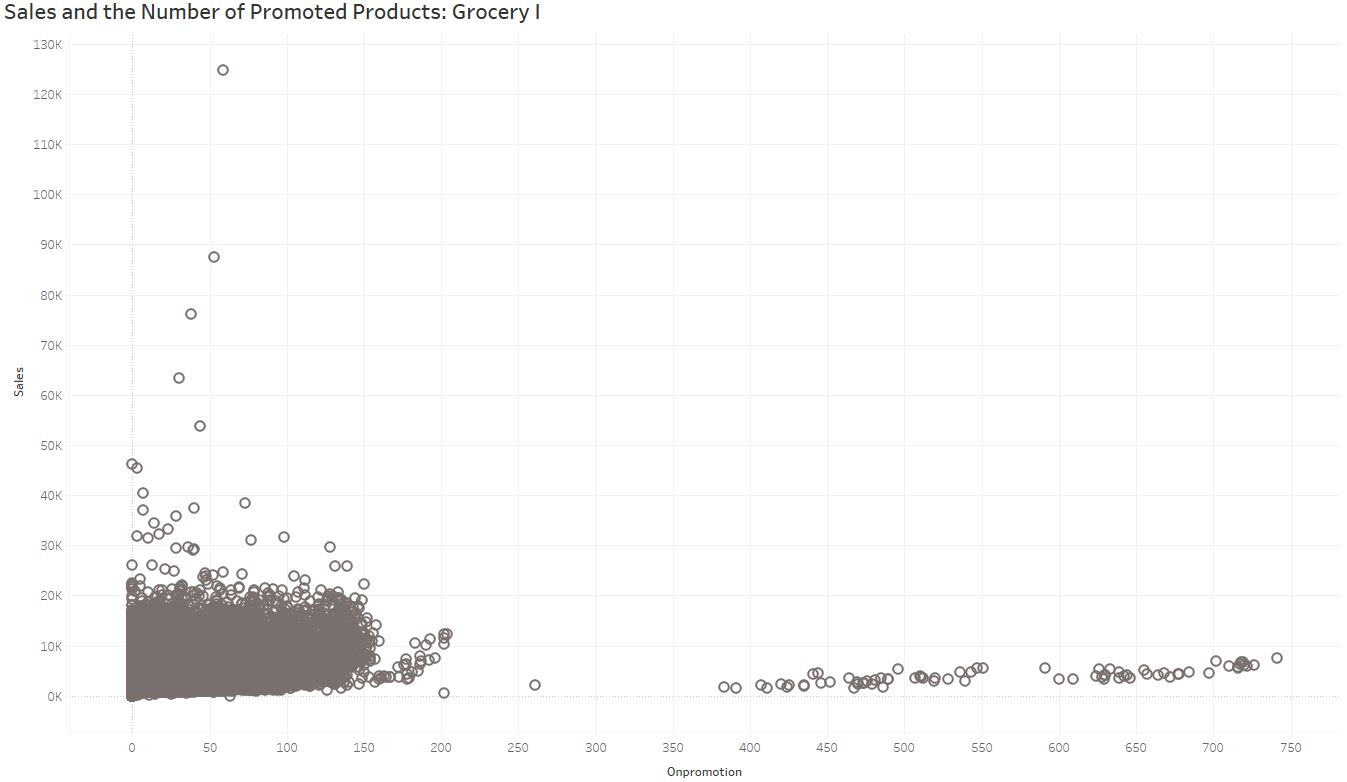

The scatter plots don't show meaningful information about the correlation between sales and the number of promoated products. Let's not use the variable because it will add some noise to the models. 

# Part 3: Modeling

## Data Preparation

Before building models, we need to do additional data preparation.

In [22]:
# create dummy variables for categorical variables
for col in ['dayofweek', 'holi_type']:
    train = pd.concat([train, pd.get_dummies(train[col])], axis=1).drop(col,axis=1)
    test = pd.concat([test, pd.get_dummies(test[col])], axis=1).drop(col,axis=1)

In [23]:
train.columns

Index([       'date',   'store_nbr',      'family',       'sales',
       'onpromotion',        'city',       'state',        'type',
           'cluster', 'holi_nation', 'holi_region',  'holi_local',
        'dcoilwtico',         'day',      'income',             0,
                   1,             2,             3,             4,
                   5,             6,  'Additional',      'Bridge',
             'Event',     'Holiday',    'Transfer',    'Work Day'],
      dtype='object')

In [24]:
test.columns

Index([       'date',   'store_nbr',      'family', 'onpromotion',
              'city',       'state',        'type',     'cluster',
       'holi_nation', 'holi_region',  'holi_local',  'dcoilwtico',
               'day',      'income',             0,             1,
                   2,             3,             4,             5,
                   6,     'Holiday'],
      dtype='object')

Test dataset doesn't have all values for the holi_type variable so the number of columns are different between train and test after creating dummy variables. Let's add the empty columns so that both can have the same shape of a dataframe.

In [25]:
# add the emply variables
test['Additional'] = 0
test['Bridge'] = 0
test['Event'] = 0
test['Transfer'] = 0
test['Work Day'] = 0

In [26]:
# check the unique values
stores = train['store_nbr'].unique()
categories = train['family'].unique()

print(stores)
print(categories)

[ 1 10 11 12 13 14 15 16 17 18 19  2 20 21 22 23 24 25 26 27 28 29  3 30
 31 32 33 34 35 36 37 38 39  4 40 41 42 43 44 45 46 47 48 49  5 50 51 52
 53 54  6  7  8  9]
['AUTOMOTIVE' 'BABY CARE' 'BEAUTY' 'BEVERAGES' 'BOOKS' 'BREAD/BAKERY'
 'CELEBRATION' 'CLEANING' 'DAIRY' 'DELI' 'EGGS' 'FROZEN FOODS' 'GROCERY I'
 'GROCERY II' 'HARDWARE' 'HOME AND KITCHEN I' 'HOME AND KITCHEN II'
 'HOME APPLIANCES' 'HOME CARE' 'LADIESWEAR' 'LAWN AND GARDEN' 'LINGERIE'
 'LIQUOR,WINE,BEER' 'MAGAZINES' 'MEATS' 'PERSONAL CARE' 'PET SUPPLIES'
 'PLAYERS AND ELECTRONICS' 'POULTRY' 'PREPARED FOODS' 'PRODUCE'
 'SCHOOL AND OFFICE SUPPLIES' 'SEAFOOD']


In [27]:
# sort the store numbers
stores = np.sort(stores)
stores

array([ 1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16, 17,
       18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34,
       35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51,
       52, 53, 54], dtype=int64)

In [28]:
print(train.shape, test.shape)

(3008280, 28) (28512, 27)


We will build a model for each category of each store using a dictionary to get better model accuracy because each has their unique pattern.

Let's create a function to subset, normalize, and clean the data. 

In [29]:
# creat dictionary
sub_train = {}
sub_test = {}

# for normalization
scaler = MinMaxScaler()

for category in categories:
    for store in stores:
        sub_train[category, store] = train[(train['family']==category)&(train['store_nbr']==store)] # subset data based on category and store
        sub_train[category, store].set_index('date', inplace=True) # set date column as index
        sub_train[category, store].drop(['store_nbr', 'family', 'day', 'type','city','state','cluster', 'onpromotion'], axis=1, inplace=True)
        train_target = sub_train[category, store]['sales']
        sub_train[category, store].drop('sales', axis=1, inplace=True) # it shouldn't be normalized
        train_column = sub_train[category, store].columns
        train_index = sub_train[category, store].index
        sub_train[category, store] = scaler.fit_transform(sub_train[category, store]) # normalization
        sub_train[category, store] = pd.DataFrame(sub_train[category, store])
        sub_train[category, store].columns = train_column
        sub_train[category, store].index = train_index
        sub_train[category, store] = pd.concat([sub_train[category, store], train_target], axis=1) # add sales columns 
             
        sub_test[category, store] = test[(test['family']==category)&(test['store_nbr']==store)] # subset data based on category and store
        sub_test[category, store].set_index('date', inplace=True) # set date column as index
        sub_test[category, store].drop(['store_nbr', 'family', 'day', 'type','city','state','cluster', 'onpromotion'], axis=1, inplace=True)
        test_column = sub_test[category, store].columns
        test_index = sub_test[category, store].index
        sub_test[category, store] = scaler.transform(sub_test[category, store]) # normalization
        sub_test[category, store] = pd.DataFrame(sub_test[category, store])
        sub_test[category, store].columns = test_column
        sub_test[category, store].index = test_index     

In [30]:
# check the result
sub_train['AUTOMOTIVE', 2].head()

,holi_nation,holi_region,holi_local,dcoilwtico,income,0,1,2,3,4,5,6,Additional,Bridge,Event,Holiday,Transfer,Work Day,sales
date,,,,,,,,,,,,,,,,,,,
2013-01-01,1.0,0.0,0.0,0.792965,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0
2013-01-02,0.0,0.0,0.0,0.792965,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,8.0
2013-01-03,0.0,0.0,0.0,0.790951,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,5.0
2013-01-04,0.0,0.0,0.0,0.792728,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,3.0
2013-01-05,1.0,0.0,0.0,0.792728,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,5.0


In [31]:
# check the result
sub_test['AUTOMOTIVE', 2].head()

,holi_nation,holi_region,holi_local,dcoilwtico,income,0,1,2,3,4,5,6,Holiday,Additional,Bridge,Event,Transfer,Work Day
date,,,,,,,,,,,,,,,,,,
2017-08-16,0.0,0.0,0.0,0.244108,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2017-08-17,0.0,0.0,0.0,0.247305,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2017-08-18,0.0,0.0,0.0,0.265309,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2017-08-19,0.0,0.0,0.0,0.265309,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2017-08-20,0.0,0.0,0.0,0.265309,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0


Some categories in stores don't have any sales history or have temporary sales. There is no meaning to train and predict for them. Let's skip modeling and predict their sales as zero for them.

In addition, some stores or categories started selling their products in the middle of the period so the data (sales=0) before starting should not be used while training models.

In [32]:
non_zero = {} # create dictionary
for category in categories:
    for store in stores:
        for i in range(0, 1684, 1):
            if sub_train[category, store]['sales'][i] != 0:
                num = i
                break
                
            else:
                num = 1683
        
        non_zero[category, store] = num
        if non_zero[category, store] > 1570:
            print(category, store, num)

BABY CARE 1 1683
BABY CARE 6 1651
BABY CARE 13 1683
BABY CARE 23 1683
BABY CARE 44 1683
BABY CARE 45 1683
BABY CARE 46 1683
BABY CARE 47 1683
BABY CARE 48 1683
BABY CARE 49 1683
BABY CARE 50 1683
BABY CARE 51 1683
BABY CARE 52 1683
BOOKS 9 1683
BOOKS 10 1683
BOOKS 11 1683
BOOKS 12 1683
BOOKS 13 1683
BOOKS 14 1683
BOOKS 15 1683
BOOKS 16 1683
BOOKS 17 1683
BOOKS 18 1683
BOOKS 19 1683
BOOKS 20 1683
BOOKS 21 1683
BOOKS 22 1683
BOOKS 28 1683
BOOKS 29 1683
BOOKS 30 1683
BOOKS 31 1683
BOOKS 32 1683
BOOKS 33 1683
BOOKS 34 1683
BOOKS 35 1683
BOOKS 36 1683
BOOKS 39 1683
BOOKS 40 1683
BOOKS 43 1683
BOOKS 52 1683
BOOKS 54 1683
LADIESWEAR 16 1683
LADIESWEAR 25 1683
LADIESWEAR 28 1683
LADIESWEAR 29 1683
LADIESWEAR 32 1683
LADIESWEAR 33 1683
LADIESWEAR 35 1683
LADIESWEAR 40 1683
LADIESWEAR 43 1683
LADIESWEAR 54 1683
LAWN AND GARDEN 14 1683
LAWN AND GARDEN 30 1683
LAWN AND GARDEN 54 1683


In [33]:
from numpy import array

# split a multivariate sequence into samples
def split_sequences(sequences, n_steps):
    X, y = list(), list()
    for i in np.arange(len(sequences)): 
        # find the end of this pattern
        end_ix = i + n_steps
        # check if we are beyond the dataset
        if end_ix > len(sequences):
            break
        # gather input and output parts of the pattern
        seq_x, seq_y = sequences[i:end_ix, :-1], sequences[end_ix-1, -1]
        X.append(seq_x)
        y.append(seq_y)
    return np.array(X), np.array(y)

In [34]:
n_steps = 1 # time steps

def dataset_prep(dataset):
    raw_seq = np.array(dataset) # store the data as a numpy array
    X, y = split_sequences(raw_seq, n_steps) # apply the function to the data
    #X=np.asarray(X).astype(np.int)
    #y=np.asarray(y).astype(np.int)
    return X, y

In [35]:
# split data into X and y for each subset
X = {} # create a dictionary
y = {} # create a dictionary

for category in categories:
    for store in stores:
        X[category, store], y[category, store] = dataset_prep(sub_train[category, store]) # apply the function to the data

In [36]:
n_steps = X['AUTOMOTIVE', 2].shape[1]
n_features = X['AUTOMOTIVE', 2].shape[2]

print(n_steps, n_features)

1 18


In [37]:
# check the shape
print(X['AUTOMOTIVE', 2].shape, y['AUTOMOTIVE', 2].shape)

(1688, 1, 18) (1688,)


In [38]:
# split a multivariate sequence into samples for test dataset
def test_sequences(sequences, n_steps):
    X = list() 
    for i in np.arange(len(sequences)): # be careful of this line!
        # find the end of this pattern
        end_ix = i + n_steps
        # check if we are beyond the dataset
        if end_ix > len(sequences):
            break
        # gather input and output parts of the pattern
        seq_x = sequences[i:end_ix]
        X.append(seq_x)
    return np.array(X)

In [39]:
# same process for test dataset except for y
def testset_prep(dataset):
    raw_seq = np.array(dataset) 
    X = test_sequences(raw_seq, n_steps)
    #X=np.asarray(X).astype(np.int)
    return X

## Data Partitioning

In [40]:
# for training
X_train = {}
X_val = {}
y_train = {}
y_val = {}
# split the data into train and validate partitions
for category in categories:
    for store in stores:
        avail = 1684 - non_zero[category, store] # no use data before staring to sell
        train_avail = int(avail*0.9)
        standard = non_zero[category, store]+train_avail # the standard to split train and validation sets
        X_train[category, store], X_val[category, store] = X[category, store][non_zero[category, store]:standard], X[category, store][standard:]
        y_train[category, store], y_val[category, store] = y[category, store][non_zero[category, store]:standard], y[category, store][standard:]

In [41]:
sub_train2 = sub_train.copy()

In [42]:
# for test
X_test = {}

for category in categories:
    for store in stores:
        sub_train2[category, store].drop('sales', axis=1, inplace=True)
        # to predict sales on test dataset using the previous data, data from the train dataset is needed
        X_test[category, store] = np.concatenate((sub_train2[category, store], sub_test[category, store]), axis=0)
        X_test[category, store] = X_test[category, store][-(15+n_steps):]
        X_test[category, store] = testset_prep(X_test[category, store])

In [43]:
print(X_test['AUTOMOTIVE', 2].shape)

(16, 1, 18)


## Building Models

Since each category and each store have different sales patterns so the same model cannot be the best for each dataset. We will build six models using LSTM and GRU with various structures for each dataset, return the best model based on Mean Squared Logarithmic Error (MSLE) for each validation set, and predict sales for each dataset with the model. 

MSLE only cares about the relative difference between the true and the predicted value, or in other words, it only cares about the percentual difference between them. Since each store or category has different ranges of sales, it's more appropriate to use for model evaluation than MSE.

In [44]:
# apply six models to each dataset using this function
def modeling(X_train, y_train, X_val, y_val, X_test):
    
    # define model1
    model = Sequential()
    model.add(Bidirectional(LSTM(200, activation='relu'), input_shape=(n_steps,n_features)))
    model.add(Dropout(0.2))
    model.add(Dense(1, kernel_constraint=nonneg())) 
    model.compile(optimizer='adam', loss=tf.keras.losses.MeanSquaredLogarithmicError(), metrics='mse')

    es = keras.callbacks.EarlyStopping(monitor='val_loss', mode='min', patience=10, restore_best_weights=True) 

    history = model.fit(X_train, y_train, callbacks=[es], epochs=200, batch_size=28, 
                         validation_split=0.2, verbose=0, shuffle=False)

    pred = model.predict(X_val) # predict sales for validation
    pred = np.where(pred<0, 0, pred) # no negative value for sales
    test = model.predict(X_test) # predict sales for test
    test = np.where(test<0, 0, test) # no negative value for sales
    
    # define model2
    model1 = Sequential()
    model1.add(LSTM(200, activation='relu', input_shape=(n_steps,n_features)))
    model1.add(Dropout(0.2))
    model1.add(Dense(1, kernel_constraint=nonneg())) 
    model1.compile(optimizer='adam', loss=tf.keras.losses.MeanSquaredLogarithmicError(), metrics='mse')

    es = keras.callbacks.EarlyStopping(monitor='val_loss', mode='min', patience=10, restore_best_weights=True) 

    history1 = model1.fit(X_train, y_train, callbacks=[es], epochs=200, batch_size=28, 
                         validation_split=0.2, verbose=0, shuffle=False)  
    
    pred1 = model.predict(X_val) # predict sales for validation
    pred1 = np.where(pred1<0, 0, pred1) # no negative value for sales
    test1 = model.predict(X_test) # predict sales for test
    test1 = np.where(test1<0, 0, test1) # no negative value for sales
    
    # define model3
    model2 = Sequential()
    model2.add(GRU(100, activation='relu', recurrent_dropout=0.2, input_shape=(n_steps, n_features)))
    model2.add(Dropout(0.2))
    model2.add(Dense(1, kernel_constraint=nonneg())) 
    model2.compile(optimizer='adam', loss=tf.keras.losses.MeanSquaredLogarithmicError(), metrics='mse')

    es = keras.callbacks.EarlyStopping(monitor='val_loss', mode='min', patience=10, restore_best_weights=True) 

    history2 = model2.fit(X_train, y_train, callbacks=[es], epochs=200, batch_size=28, 
                          validation_split=0.2,verbose=0, shuffle=False)
    
    pred2 = model2.predict(X_val) # predict sales for validation
    pred2 = np.where(pred2<0, 0, pred2) # no negative value for sales
    test2 = model2.predict(X_test) # predict sales for test
    test2 = np.where(test2<0, 0, test2) # no negative value for sales
    
    # define model4
    model3 = Sequential()
    model3.add(Bidirectional(GRU(200, activation='relu', return_sequences=True), input_shape=(n_steps,n_features)))
    model3.add(Bidirectional(GRU(100, activation='relu', return_sequences=True)))
    model3.add(LSTM(50, activation='relu'))
    model3.add(Dropout(0.2)) 
    model3.add(Dense(1, kernel_constraint=nonneg()))
    model3.compile(optimizer='adam', loss=tf.keras.losses.MeanSquaredLogarithmicError(), metrics='mse')

    es = keras.callbacks.EarlyStopping(monitor='val_loss', mode='min', patience=10, restore_best_weights=True) 

    history3 = model3.fit(X_train, y_train, callbacks=[es], epochs=200, batch_size=28, 
                          validation_split=0.2,verbose=0, shuffle=False)

    pred3 = model3.predict(X_val) # predict sales for validation
    pred3 = np.where(pred3<0, 0, pred3) # no negative value for sales
    test3 = model3.predict(X_test) # predict sales for test
    test3 = np.where(test3<0, 0, test3) # no negative value for sales
    
    # define model5
    model4 = Sequential()
    model4.add(Bidirectional(LSTM(200, activation='relu', return_sequences=True), input_shape=(n_steps,n_features)))
    model4.add(Bidirectional(LSTM(100, activation='relu', return_sequences=True)))
    model4.add(GRU(50, activation='relu'))
    model4.add(Dropout(0.1)) 
    model4.add(Dense(1, kernel_constraint=nonneg()))
    model4.compile(optimizer='adam', loss=tf.keras.losses.MeanSquaredLogarithmicError(), metrics='mse')

    es = keras.callbacks.EarlyStopping(monitor='val_loss', mode='min', patience=10, restore_best_weights=True) 

    history4 = model4.fit(X_train, y_train, callbacks=[es], epochs=200, batch_size=28, 
                          validation_split=0.2,verbose=0, shuffle=False)

    pred4 = model4.predict(X_val) # predict sales for validation
    pred4 = np.where(pred4<0, 0, pred4) # no negative value for sales
    test4 = model4.predict(X_test) # predict sales for test
    test4 = np.where(test4<0, 0, test4) # no negative value for sales
    
    # define model6
    model5 = Sequential()
    model5.add(Bidirectional(SimpleRNN(200, activation='relu', return_sequences=True), input_shape=(n_steps,n_features)))
    model5.add(Bidirectional(SimpleRNN(100, activation='relu')))
    model5.add(Dropout(0.1)) 
    model5.add(Dense(1, kernel_constraint=nonneg()))
    model5.compile(optimizer='adam', loss=tf.keras.losses.MeanSquaredLogarithmicError(), metrics='mse')

    es = keras.callbacks.EarlyStopping(monitor='val_loss', mode='min', patience=10, restore_best_weights=True) 

    history5 = model5.fit(X_train, y_train, callbacks=[es], epochs=200, batch_size=28, 
                          validation_split=0.2,verbose=0, shuffle=False)

    pred5 = model5.predict(X_val) # predict sales for validation
    pred5 = np.where(pred5<0, 0, pred5) # no negative value for sales
    test5 = model5.predict(X_test) # predict sales for test
    test5 = np.where(test5<0, 0, test5) # no negative value for sales
    
    return mean_squared_log_error(y_val, pred), pred, test, mean_squared_log_error(y_val, pred1), pred1, test1, mean_squared_log_error(y_val, pred2), pred2, test2,\
            mean_squared_log_error(y_val, pred3), pred3, test3, mean_squared_log_error(y_val, pred4), pred4, test4, mean_squared_log_error(y_val, pred5), pred5, test5

In [45]:
X_total = {}
pred_value = {}
val_pred = {}
for category in categories:
    for store in stores:
        if non_zero[category, store] > 1570:
            continue # no training for zero sales dataset
        
        else:
            model0_msle, pred0, test0, model1_msle, pred1, test1, model2_msle, pred2, test2, model3_msle, pred3, test3, model4_msle, pred4, test4, model5_msle, pred5, test5 = \
            modeling(X_train[category, store], y_train[category, store], X_val[category, store], y_val[category, store], X_test[category, store]) 
            msles = [model0_msle, model1_msle, model2_msle, model3_msle, model4_msle, model5_msle]
            
            if msles[0] == min(msles):
                best = 'model0'
                pred = pred0
                pred_test = test0
            elif msles[1] == min(msles):
                best = 'model1'
                pred = pred1 
                pred_test = test1
            elif msles[2] == min(msles):
                best = 'model2'
                pred = pred2
                pred_test = test2
            elif msles[3] == min(msles):
                best = 'model3'
                pred = pred3 
                pred_test = test3
            elif msles[4] == min(msles):
                best = 'model4'
                pred = pred4 
                pred_test = test4
            elif msles[5] == min(msles):
                best = 'model5'
                pred = pred5 
                pred_test = test5
                
        val_pred[category, store] = pred 
        pred_value[category, store] = pred_test       
        print(category, store, best, 'MSLE: ', mean_squared_log_error(y_val[category, store], pred))       

AUTOMOTIVE 1 model3 MSLE:  0.2874848403772458
AUTOMOTIVE 2 model5 MSLE:  0.3467454256231154
AUTOMOTIVE 3 model3 MSLE:  0.14509188280737573
AUTOMOTIVE 4 model3 MSLE:  0.277139029922469
AUTOMOTIVE 5 model5 MSLE:  0.19890398071644072
AUTOMOTIVE 6 model3 MSLE:  0.2467496294583491
AUTOMOTIVE 7 model3 MSLE:  0.29777271125611715
AUTOMOTIVE 8 model5 MSLE:  0.2887283038010045
AUTOMOTIVE 9 model0 MSLE:  0.23486284411676703
AUTOMOTIVE 10 model0 MSLE:  0.3994980160078273
AUTOMOTIVE 11 model3 MSLE:  0.2715737690388486
AUTOMOTIVE 12 model3 MSLE:  0.2720048195655132
AUTOMOTIVE 13 model2 MSLE:  0.2985460170866567
AUTOMOTIVE 14 model3 MSLE:  0.3977818533069343
AUTOMOTIVE 15 model3 MSLE:  0.33610963555940826
AUTOMOTIVE 16 model0 MSLE:  0.3054951558887328
AUTOMOTIVE 17 model3 MSLE:  0.32033490502739165
AUTOMOTIVE 18 model3 MSLE:  0.31945845716598686
AUTOMOTIVE 19 model4 MSLE:  0.28153288421325934
AUTOMOTIVE 20 model0 MSLE:  0.2648011817964899
AUTOMOTIVE 21 model0 MSLE:  0.15759647694867712
AUTOMOTIVE 22 

BEAUTY 54 model3 MSLE:  0.4469472124660245
BEVERAGES 1 model3 MSLE:  0.07972946845408435
BEVERAGES 2 model4 MSLE:  0.06764024062243029
BEVERAGES 3 model3 MSLE:  0.09119916965744695
BEVERAGES 4 model3 MSLE:  0.0996637661942114
BEVERAGES 5 model3 MSLE:  0.07149098946178538
BEVERAGES 6 model4 MSLE:  0.11652876460648379
BEVERAGES 7 model3 MSLE:  0.06908769871173179
BEVERAGES 8 model3 MSLE:  0.08619381497381416
BEVERAGES 9 model3 MSLE:  0.13001586035353233
BEVERAGES 10 model4 MSLE:  0.15257017282753782
BEVERAGES 11 model3 MSLE:  0.07073731245939899
BEVERAGES 12 model3 MSLE:  0.766976975380003
BEVERAGES 13 model5 MSLE:  0.06481676037268762
BEVERAGES 14 model5 MSLE:  0.2561299075095531
BEVERAGES 15 model3 MSLE:  0.09719426333743332
BEVERAGES 16 model3 MSLE:  0.08865598350026416
BEVERAGES 17 model3 MSLE:  0.1472589428372816
BEVERAGES 18 model3 MSLE:  6.006204350534717
BEVERAGES 19 model5 MSLE:  0.07167807926375933
BEVERAGES 20 model4 MSLE:  0.19303793033918773
BEVERAGES 21 model3 MSLE:  0.0964

CELEBRATION 39 model5 MSLE:  0.49383031313618736
CELEBRATION 40 model4 MSLE:  0.700184756370513
CELEBRATION 41 model0 MSLE:  0.5744026983132248
CELEBRATION 42 model5 MSLE:  0.29685218114754836
CELEBRATION 43 model3 MSLE:  1.3989775121303476
CELEBRATION 44 model0 MSLE:  0.5480462765129469
CELEBRATION 45 model5 MSLE:  0.5989686173751475
CELEBRATION 46 model0 MSLE:  0.36703388170431667
CELEBRATION 47 model3 MSLE:  0.5571589129463299
CELEBRATION 48 model5 MSLE:  0.4063047300592504
CELEBRATION 49 model0 MSLE:  0.5387421318282694
CELEBRATION 50 model0 MSLE:  0.6772685791188531
CELEBRATION 51 model2 MSLE:  0.31096115639346456
CELEBRATION 52 model2 MSLE:  0.1511162632046235
CELEBRATION 53 model4 MSLE:  0.3276153649610186
CELEBRATION 54 model0 MSLE:  0.5107140454934634
CLEANING 1 model3 MSLE:  0.03245912106644785
CLEANING 2 model3 MSLE:  0.03397604973293509
CLEANING 3 model3 MSLE:  0.04344312770732474
CLEANING 4 model3 MSLE:  0.039645240810467094
CLEANING 5 model2 MSLE:  0.03506944821899552
CLE

EGGS 11 model3 MSLE:  0.3032785617735905
EGGS 12 model3 MSLE:  0.2629305813260824
EGGS 13 model5 MSLE:  0.356242684332734
EGGS 14 model3 MSLE:  0.22114275292123983
EGGS 15 model3 MSLE:  0.18004399558964462
EGGS 16 model0 MSLE:  0.22082864341094746
EGGS 17 model3 MSLE:  0.2036684925090372
EGGS 18 model4 MSLE:  0.6985618161191547
EGGS 19 model3 MSLE:  0.17464965697829704
EGGS 20 model5 MSLE:  0.17156755157589923
EGGS 21 model3 MSLE:  0.2788908133904352
EGGS 22 model3 MSLE:  0.2348477745977615
EGGS 23 model5 MSLE:  0.034100060323763844
EGGS 24 model4 MSLE:  0.0339344058803405
EGGS 25 model4 MSLE:  0.3648001785871838
EGGS 26 model3 MSLE:  0.060142152026176954
EGGS 27 model4 MSLE:  0.04567913233422069
EGGS 28 model3 MSLE:  0.1276013425029545
EGGS 29 model3 MSLE:  0.1360856137851307
EGGS 30 model5 MSLE:  0.15416225652660406
EGGS 31 model3 MSLE:  0.11284535851253173
EGGS 32 model5 MSLE:  0.23878797711534813
EGGS 33 model5 MSLE:  0.2090030470521835
EGGS 34 model3 MSLE:  0.21078357687981844
EGG

GROCERY II 26 model5 MSLE:  0.9181725186771422
GROCERY II 27 model4 MSLE:  0.21497961343017963
GROCERY II 28 model3 MSLE:  0.5658089010201393
GROCERY II 29 model2 MSLE:  0.5400292073790155
GROCERY II 30 model5 MSLE:  0.6378791758723888
GROCERY II 31 model3 MSLE:  0.2688028052109308
GROCERY II 32 model3 MSLE:  0.5316941571902902
GROCERY II 33 model2 MSLE:  0.6230203243955138
GROCERY II 34 model2 MSLE:  0.6788119040298914
GROCERY II 35 model5 MSLE:  0.7436768351191594
GROCERY II 36 model0 MSLE:  0.9417644985682905
GROCERY II 37 model3 MSLE:  0.15332814101642797
GROCERY II 38 model2 MSLE:  0.13677590224679972
GROCERY II 39 model3 MSLE:  0.1862679719797448
GROCERY II 40 model3 MSLE:  0.35688987106148273
GROCERY II 41 model4 MSLE:  0.23641041378763628
GROCERY II 42 model0 MSLE:  0.2251625068552272
GROCERY II 43 model4 MSLE:  1.4046956142484295
GROCERY II 44 model5 MSLE:  0.11876647010381418
GROCERY II 45 model3 MSLE:  0.33782527824352215
GROCERY II 46 model3 MSLE:  0.2173202353789583
GROCER

HOME AND KITCHEN II 26 model3 MSLE:  0.34090135091017054
HOME AND KITCHEN II 27 model3 MSLE:  0.2824643154092917
HOME AND KITCHEN II 28 model0 MSLE:  0.20416358863349854
HOME AND KITCHEN II 29 model3 MSLE:  0.19913216763661246
HOME AND KITCHEN II 30 model2 MSLE:  0.3577776407309302
HOME AND KITCHEN II 31 model3 MSLE:  0.13699513062744628
HOME AND KITCHEN II 32 model5 MSLE:  0.2953797030661839
HOME AND KITCHEN II 33 model3 MSLE:  0.17052463263278414
HOME AND KITCHEN II 34 model5 MSLE:  0.2758846170264782
HOME AND KITCHEN II 35 model3 MSLE:  0.2794896078997358
HOME AND KITCHEN II 36 model3 MSLE:  0.2793321331232741
HOME AND KITCHEN II 37 model4 MSLE:  0.2634572638290725
HOME AND KITCHEN II 38 model0 MSLE:  1.4207612072736344
HOME AND KITCHEN II 39 model4 MSLE:  0.13524319237116172
HOME AND KITCHEN II 40 model0 MSLE:  0.23899540345728965
HOME AND KITCHEN II 41 model3 MSLE:  0.2878130679590505
HOME AND KITCHEN II 42 model4 MSLE:  0.2573160261485965
HOME AND KITCHEN II 43 model3 MSLE:  0.30

LADIESWEAR 34 model2 MSLE:  0.5972995558721741
LADIESWEAR 36 model5 MSLE:  4.50640092522772e-06
LADIESWEAR 37 model0 MSLE:  0.5189219434151527
LADIESWEAR 38 model5 MSLE:  0.5055396740236463
LADIESWEAR 39 model0 MSLE:  0.5040045421619324
LADIESWEAR 41 model0 MSLE:  1.31380510200789
LADIESWEAR 42 model4 MSLE:  0.22441960292203508
LADIESWEAR 44 model0 MSLE:  0.6390549275538745
LADIESWEAR 45 model0 MSLE:  0.8748620302967804
LADIESWEAR 46 model4 MSLE:  0.808358789448302
LADIESWEAR 47 model5 MSLE:  0.795169155799191
LADIESWEAR 48 model0 MSLE:  0.7202183873887739
LADIESWEAR 49 model0 MSLE:  0.7350160374438427
LADIESWEAR 50 model5 MSLE:  0.6214573679641648
LADIESWEAR 51 model2 MSLE:  0.656670785888694
LADIESWEAR 52 model4 MSLE:  0.08891627048047918
LADIESWEAR 53 model4 MSLE:  0.5750101476233761
LAWN AND GARDEN 1 model3 MSLE:  0.6216457387239982
LAWN AND GARDEN 2 model3 MSLE:  1.0040265488568632
LAWN AND GARDEN 3 model3 MSLE:  1.2723241415111661
LAWN AND GARDEN 4 model3 MSLE:  1.084434321052243

LIQUOR,WINE,BEER 48 model3 MSLE:  2.089302163898262
LIQUOR,WINE,BEER 49 model3 MSLE:  3.0163907135684798
LIQUOR,WINE,BEER 50 model4 MSLE:  2.056433408454798
LIQUOR,WINE,BEER 51 model4 MSLE:  2.3183542952481937
LIQUOR,WINE,BEER 52 model4 MSLE:  0.1442731655971985
LIQUOR,WINE,BEER 53 model3 MSLE:  0.8282966791688697
LIQUOR,WINE,BEER 54 model3 MSLE:  0.8350723196232822
MAGAZINES 1 model5 MSLE:  0.7323538102642554
MAGAZINES 2 model5 MSLE:  0.9549218143053251
MAGAZINES 3 model5 MSLE:  1.3245474635061565
MAGAZINES 4 model5 MSLE:  0.8091591354218688
MAGAZINES 5 model5 MSLE:  0.45791963070364866
MAGAZINES 6 model2 MSLE:  0.9168585475567872
MAGAZINES 7 model0 MSLE:  0.6961369372369984
MAGAZINES 8 model0 MSLE:  1.2612798873041744
MAGAZINES 9 model5 MSLE:  0.8082856508830699
MAGAZINES 10 model5 MSLE:  0.2535152492021228
MAGAZINES 11 model5 MSLE:  0.6966109842219268
MAGAZINES 12 model5 MSLE:  0.4585175725900843
MAGAZINES 13 model3 MSLE:  0.3371689850856343
MAGAZINES 14 model5 MSLE:  0.380734141019

PET SUPPLIES 7 model4 MSLE:  0.6659938242323169
PET SUPPLIES 8 model0 MSLE:  0.8229730693475554
PET SUPPLIES 9 model2 MSLE:  0.8593947237184122
PET SUPPLIES 10 model5 MSLE:  0.33865638856325025
PET SUPPLIES 11 model3 MSLE:  0.420131644714289
PET SUPPLIES 12 model3 MSLE:  0.46230655712025986
PET SUPPLIES 13 model5 MSLE:  0.2868450703749718
PET SUPPLIES 14 model3 MSLE:  0.4264721142143024
PET SUPPLIES 15 model5 MSLE:  0.42155454762063743
PET SUPPLIES 16 model4 MSLE:  0.5898417656575172
PET SUPPLIES 17 model3 MSLE:  0.5667197857382632
PET SUPPLIES 18 model5 MSLE:  1.0407829092940368
PET SUPPLIES 19 model3 MSLE:  0.3244936740865106
PET SUPPLIES 20 model5 MSLE:  0.44055841730914785
PET SUPPLIES 21 model4 MSLE:  0.6157251574778826
PET SUPPLIES 22 model2 MSLE:  0.32705666751060386
PET SUPPLIES 23 model3 MSLE:  0.5487337471325283
PET SUPPLIES 24 model2 MSLE:  0.6640508264158803
PET SUPPLIES 25 model3 MSLE:  0.5995079433190967
PET SUPPLIES 26 model3 MSLE:  0.8831078962882657
PET SUPPLIES 27 mod

PREPARED FOODS 5 model2 MSLE:  0.09319773737237001
PREPARED FOODS 6 model0 MSLE:  0.09940908920501554
PREPARED FOODS 7 model2 MSLE:  0.07059335978757317
PREPARED FOODS 8 model4 MSLE:  0.06245537778557402
PREPARED FOODS 9 model0 MSLE:  0.18758413063905965
PREPARED FOODS 10 model3 MSLE:  0.16948407517367622
PREPARED FOODS 11 model5 MSLE:  0.37379969624494663
PREPARED FOODS 12 model0 MSLE:  0.23227793551964754
PREPARED FOODS 13 model0 MSLE:  0.21259350865599444
PREPARED FOODS 14 model5 MSLE:  0.17068557708780585
PREPARED FOODS 15 model3 MSLE:  0.22323507139352847
PREPARED FOODS 16 model0 MSLE:  0.13746050155435255
PREPARED FOODS 17 model0 MSLE:  0.08397866987979676
PREPARED FOODS 18 model3 MSLE:  0.8716823579467707
PREPARED FOODS 19 model3 MSLE:  0.10640936454434549
PREPARED FOODS 20 model2 MSLE:  0.04564018941153058
PREPARED FOODS 21 model4 MSLE:  0.3738942586978617
PREPARED FOODS 22 model5 MSLE:  0.20689176986810331
PREPARED FOODS 23 model0 MSLE:  0.10060515762676281
PREPARED FOODS 24 m

SCHOOL AND OFFICE SUPPLIES 54 model4 MSLE:  1.1370138314839473
SEAFOOD 1 model4 MSLE:  0.09742948652859683
SEAFOOD 2 model3 MSLE:  0.08144524126965841
SEAFOOD 3 model4 MSLE:  0.05457775216769433
SEAFOOD 4 model5 MSLE:  0.08599393036478292
SEAFOOD 5 model0 MSLE:  0.17998753899338116
SEAFOOD 6 model4 MSLE:  0.0828941618171384
SEAFOOD 7 model0 MSLE:  0.0950285157466331
SEAFOOD 8 model4 MSLE:  0.09184305873124603
SEAFOOD 9 model3 MSLE:  0.18932214395144395
SEAFOOD 10 model2 MSLE:  0.7002006949512911
SEAFOOD 11 model3 MSLE:  0.30784270235035627
SEAFOOD 12 model3 MSLE:  0.7242051844402899
SEAFOOD 13 model3 MSLE:  0.4785786954029978
SEAFOOD 14 model2 MSLE:  0.5513290604381188
SEAFOOD 15 model3 MSLE:  0.3402471846855029
SEAFOOD 16 model2 MSLE:  0.4001921132455455
SEAFOOD 17 model3 MSLE:  0.24336177963305078
SEAFOOD 18 model5 MSLE:  0.6832217447080416
SEAFOOD 19 model4 MSLE:  0.37046609713456946
SEAFOOD 20 model3 MSLE:  0.23169815962301912
SEAFOOD 21 model3 MSLE:  0.3586729301019229
SEAFOOD 22 

In [ ]:
plt.figure(figsize=(25, 1000))
i = 1
for category in categories:
    for store in stores:
        title = str(category)+str(store)
        if non_zero[category, store] > 1570:
            continue # no training for zero sales dataset
            
        plt.subplot(446, 4, i)  
        plt.plot(np.arange(X_val[category, store].shape[0]), y_val[category, store], color='blue') 
        plt.plot(np.arange(X_val[category, store].shape[0]), val_pred[category, store], color='red') 
        plt.title(title, fontsize=12)
        plt.xticks(fontsize=10)
        plt.yticks(fontsize=10)
        plt.xlabel('Time', fontsize=10)
        plt.ylabel('sales', fontsize=10)
        i += 1      
        
plt.show()      

## Model Evaluation

We've got the predicted values for each test dataset. We will combine them into one dataset, match the predicted values with the id variable, and evaluate the predictive model using RMSLE by submitting on the Kaggle website. 

In [103]:
test2 = pd.read_csv("test.csv")
print(test2.shape)
test2.head()

(28512, 5)


,id,date,store_nbr,family,onpromotion
0,3000888,2017-08-16,1,AUTOMOTIVE,0
1,3000889,2017-08-16,1,BABY CARE,0
2,3000890,2017-08-16,1,BEAUTY,2
3,3000891,2017-08-16,1,BEVERAGES,20
4,3000892,2017-08-16,1,BOOKS,0


In [104]:
test2.set_index('date', inplace=True)

In [105]:
test2 = test2.sort_values(["family", "store_nbr"], ascending = (True, True))
test2.reset_index(drop=True, inplace=True)
print(test2.shape)
test2.head(20)

(28512, 4)


,id,store_nbr,family,onpromotion
0,3000888,1,AUTOMOTIVE,0
1,3002670,1,AUTOMOTIVE,0
2,3004452,1,AUTOMOTIVE,0
3,3006234,1,AUTOMOTIVE,0
4,3008016,1,AUTOMOTIVE,0
5,3009798,1,AUTOMOTIVE,0
6,3011580,1,AUTOMOTIVE,0
7,3013362,1,AUTOMOTIVE,0
8,3015144,1,AUTOMOTIVE,0
9,3016926,1,AUTOMOTIVE,0


As mentioned earlier, we will set the predicted values to zero for some stores' categories which have no sales record.

In [ ]:
zero = np.array([[0],[0],[0],[0],[0],[0],[0],[0],[0],[0],[0],[0],[0],[0],[0],[0]])
zero = pd.DataFrame(zero)

In [107]:
# combine the predicted values from each category datasets into one
sales_pred = pd.DataFrame()

for category in categories:
    for store in stores:
        if non_zero[category, store] > 1570:
            sales_pred = pd.concat([sales_pred, zero])
        else:
            pred_value[category, store] = pd.DataFrame(pred_value[category, store])
            sales_pred = pd.concat([sales_pred, pred_value[category, store]])

sales_pred.reset_index(drop=True, inplace=True)                      
sales_pred

,0
0,3.575094
1,2.871974
2,3.793731
3,3.899616
4,1.183807
...,...
28507,1.538229
28508,1.082730
28509,0.965012
28510,1.120507


In [109]:
# to match the predicted values to id
sub = pd.concat([test2, sales_pred], axis=1)
sub.drop(['store_nbr', 'family', 'onpromotion'], axis=1, inplace=True)
sub.columns = ['id', 'sales']
sub

,id,sales
0,3000888,3.575094
1,3002670,2.871974
2,3004452,3.793731
3,3006234,3.899616
4,3008016,1.183807
...,...,...
28507,3022139,1.538229
28508,3023921,1.082730
28509,3025703,0.965012
28510,3027485,1.120507


In [110]:
sub.to_csv('submission_final_1_28_msle.csv', index=False)

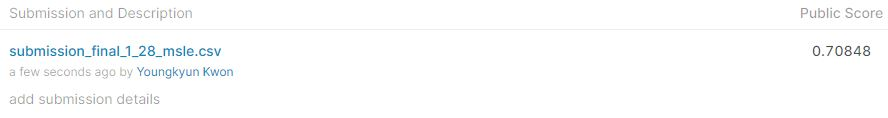

# Conclusion

- We can predict sales of each category by each store at the level of RMSLE 0.708.
- Using this model, the company will be able to develop business plans regarding sales operations with territory and quota planning, and supply chain with product purchases to satisfy customers by having just enough of the right products at the right time.
- In addition, the company can reduce the costs for a warehouse due to overstocks and disposing of spoiled products.
- Some stores and categories don't have enough data to predict accurately. As the data is collected over time, the model accuracy will be improved with more abundant data. 